# Photometry

In this part of the workshop we will load the raw images and extract the photometry of the stars in the field.

## Exploring the data folder

Let's start by exploring the folder of raw data using the `FitsManager` object from prose

In [1]:
from prose import FitsManager

fits_folder = "../raw_data/T1_201509"
fm = FitsManager(fits_folder, depth=3)
fm

/Users/lgarcia/mambaforge/envs/pysnack10/lib/python3.11/site-packages/prose/console_utils.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Parsing FITS: 100%|██████████| 838/838 [00:00<00:00, 1424.55it/s]


,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
24,2015-09-16,TRAPPIST-South,,bias,,2096,2080,11
17,2015-09-16,TRAPPIST-South,,dark,,2096,2080,52
2,2015-09-16,TRAPPIST-South,I+z,light,UCDTS-48,2096,2080,163
55,2015-09-17,TRAPPIST-South,I+z,flat,,2096,2080,30
12,2015-09-28,TRAPPIST-South,,bias,,2096,2080,30
6,2015-09-28,TRAPPIST-South,,dark,,2096,2080,90
63,2015-09-28,TRAPPIST-South,I+z,flat,,2096,2080,30
1,2015-09-28,TRAPPIST-South,I+z,light,UCDTS-48,2096,2080,432


As you can see the folder contains several images, some of them used for calibration of the science frames. We can use the `FitsManager` to select images associated to a certain night together with the corresponding calibration files.

In [2]:
files = fm.observation_files(2)

/Users/lgarcia/mambaforge/envs/pysnack10/lib/python3.11/site-packages/prose/io/fitsmanager.py:537: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, axis=0).set_index(["id"])


,date,telescope,filter,type,target,width,height,exposure,files
id,,,,,,,,,
2,2015-09-16,TRAPPIST-South,I+z,light,UCDTS-48,2096,2080,55.0,163
17,2015-09-16,TRAPPIST-South,,dark,,2096,2080,10.0,11
8,2015-09-16,TRAPPIST-South,,dark,,2096,2080,20.0,11
5,2015-09-16,TRAPPIST-South,,dark,,2096,2080,55.0,30
24,2015-09-16,TRAPPIST-South,,bias,,2096,2080,0.0,11


## Processing a reference image

In order to perform the photometric extraction of stars fluxes on all images, we will select a reference image from which we will extract:

- The stars positions, then reused and detected on all images (after being aligned to the reference)
- The global full-width at half-maximum (fwhm) of the PSF, to scale the apertures used in the aperture photometry block


In [3]:
import numpy as np
from prose import FITSImage, Sequence, blocks

# reference is middle image
ref = FITSImage(files["images"][len(files["images"]) // 2])

```{note}
[FITSImage](prose.FITSImage) is the primary function used to load a FITS image into an [Image](prose.Image) object. While other loaders can be used, this loader is compatible with most of the images aquired from small to large-size ground-based telescopes.
```

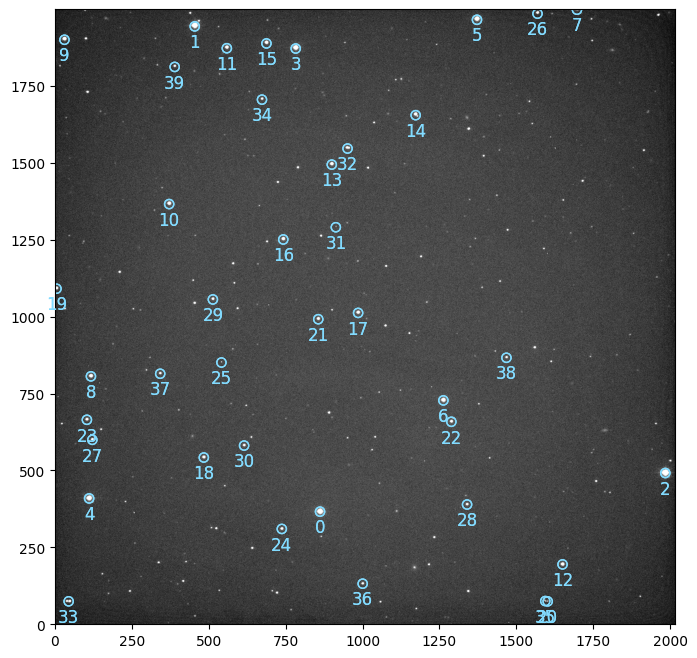

In [4]:
calibration = Sequence(
    [
        blocks.Calibration(
            darks=files["darks"], bias=files["bias"], flats=files["flats"]
        ),
        blocks.Trim(),
        blocks.PointSourceDetection(n=40),  # stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.psf.Gaussian2D(),  # modeling EPSF
    ]
)

calibration.run(ref, show_progress=False)
ref.show()
ref.sources.plot()

## Identifying the target

In this image, we may want to identify the target by making a query to a catalog such as Gaia. During the original TRAPPIST, TRAPPIST-1 (located in this image) had not be named yet. One way to identify the target in the field was to check its coordinates and plot it on top of the image. Let's do that here.

The coordinate of  (the original name of TRAPPIST-1) are

- RA: `23h 6m 29s `
- Dec: `-5° 2′ 29″`

We first create an astropy [SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) object containing these coordinates

In [5]:
from astropy.coordinates import SkyCoord

target_coordinates = SkyCoord("23h 6m 29s", "-5° 2′ 29″")

We then plot this coordinate on top of the image. To do that the image must be plate solved. Let's check if that's the case

In [6]:
ref.plate_solved

True

If not you can follow [this tutorial](https://prose.readthedocs.io/en/latest/ipynb/catalogs.html) in prose's documentation. We will now transform the sky coordinate into a pixel coordinate and plot it

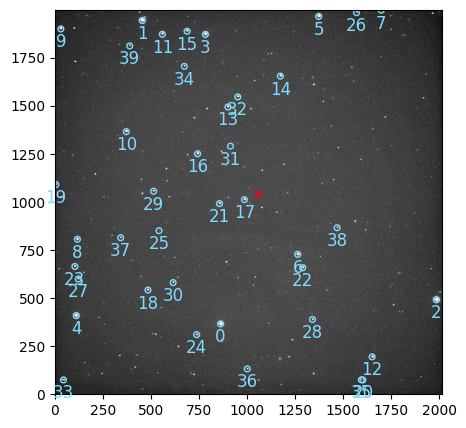

In [7]:
import matplotlib.pyplot as plt

x, y = ref.wcs.all_world2pix(target_coordinates.ra.deg, target_coordinates.dec.deg, 0)

ref.show(figsize=5)
plt.plot(x, y, "rx")

We have not included the proper motion of the star here but doing so would point to our target in the field.

## Aperture photometry

We can now extract the photometry of these stars using this sequence

In [8]:
photometry = Sequence(
    [
        calibration[0],  # calibration block (same as above)
        blocks.Trim(),
        blocks.PointSourceDetection(n=20, minor_length=8),  # fewer stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.GetFluxes(
            "fwhm",
            flip=lambda im: im.header["PIERSIDE"] == "EAST",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ]
)

In this sequence, we performed aperture photometry with a bunch of other image processing steps. Let plot the different apertures we used.

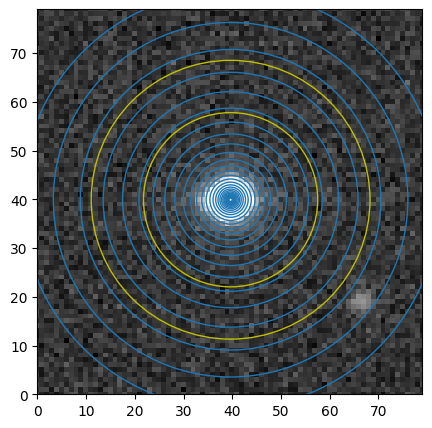

In [9]:
# we isolate the aperture photometry block
ap_phot_block: blocks.AperturePhotometry = photometry[9]
annulus_block: blocks.AnnulusBackground = photometry[10]
radii = ap_phot_block._radii.copy()

ref_cutout = ref.cutout(17, 80)
ref_cutout.show(sources=False, figsize=5)
for r in radii * ref.fwhm:
    ref_cutout.sources[0].plot(r, label=False, c="C0")

ref_cutout.sources[0].plot(annulus_block.rin * ref.fwhm, label=False, c="y")
ref_cutout.sources[0].plot(annulus_block.rout * ref.fwhm, label=False, c="y")

- In yellow: we plotted the size of the annulus used to compute the local background of the target.
- In blue: we plotted all the apertures on which we extract the photometry.

```{note}
As you may notice, the apertures do not seem optimally set for our observation. This is expected as the default values of the `AperturePhotometry` and `AnnulusBackground` are set to accommodate very generic observations. As an exercise, try to specify some optimal apertures and annulus for this observation when instantiating these two blocks in the sequence.
```

Let's run the sequence

In [10]:
photometry.run(files["images"])

100%|██████████| 163/163 [00:40<00:00,  4.05images/s]


## The [Fluxes](prose.Fluxes) object

The [GetFluxes](prose.blocks.GetFluxes) block provide a way to retrieve the fluxes computed by the [AperturePhotometry](prose.blocks.AperturePhotometry) minus the background estimated with [AnnulusBackground](prose.blocks.AnnulusBackground)

In [11]:
from prose import Fluxes

raw_fluxes: Fluxes = photometry[-1].fluxes
fluxes = raw_fluxes.copy()

we can then produce the differential photometry with `autodiff`

In [12]:
import matplotlib.pyplot as plt

fluxes.target = 17

# a bit of cleaning
nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2))  # stars with nan fluxes
fluxes = fluxes.mask_stars(~nan_stars)  # mask nans stars
fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3)  # sigma clipping

# differential photometry
diff = fluxes.autodiff()

Let's plot the differential light curve

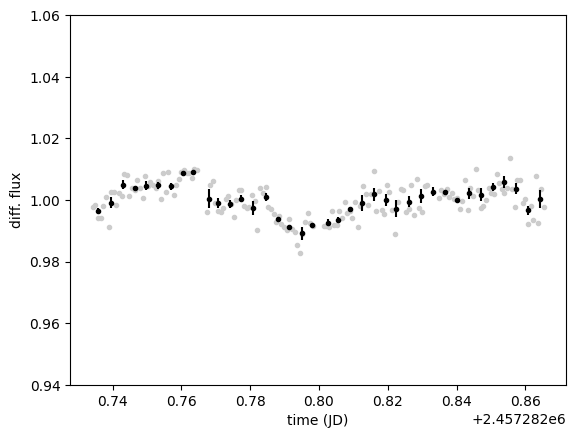

In [13]:
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux", ylim=(0.94, 1.06))
diff.plot()
diff.bin(5 / 60 / 24, estimate_error=True).errorbar()

We can also pick the selection stars by hand

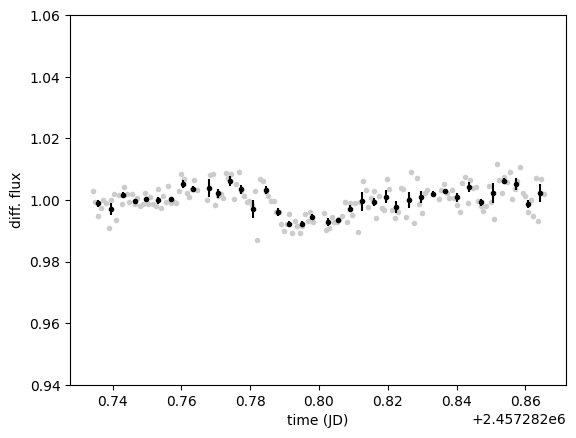

In [14]:
# manual differential photometry
diff = fluxes.diff([6, 4, 13, 21, 16])
# picking best aperture
diff.aperture = diff.best_aperture_index()

ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux", ylim=(0.94, 1.06))
diff.plot()
diff.bin(5 / 60 / 24, estimate_error=True).errorbar()

Let's save these data to analyze them in the next notebook

In [15]:
diff.save(f"../data/{ref.label}.flux")

## Finding the proper citations

`prose` depends on a lot of Python packages and published methods. When using prose in your research, you can generate a complete aknowledgment sentence (and associated BibTeX entries) based on the blocks used in a [Sequence](prose.Sequence).

For example, given our photometry sequence, citations can be extracted with


In [16]:
acknowledgement, bibtex = photometry.citations()

where `acknowledgement` contains the aknowledgment sentence and `bibtex` the necessary BibTeX entries. Please make sure to check the generated text and BibTeX entries before using them in your work.

In [17]:
print(acknowledgement, "\n")
print(bibtex[:500], "...")

This research made use of \textsf{prose} \citep{prose} and its dependencies (photutils \citep{photutils}, scikit-image \citep{scikit-image}, scipy \citep{scipy}, numpy \citep{numpy} and astropy \citep{astropy}). 


@software{photutils,
author       = {Larry Bradley and
                Brigitta Sipőcz and
                Thomas Robitaille and
                Erik Tollerud and
                Zé Vinícius and
                Christoph Deil and
                Kyle Barbary and
                Tom J Wilson and
                Ivo Busko and
                Axel Donath and
                Hans Moritz Günther and
                Mihai Cara and
                P. L. Lim and
                Sebastian Meßlinger and
 ...
